In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
import tweepy

from datetime import datetime
from functools import reduce

% matplotlib inline

## Gathering

In [2]:
# Read The WeRateDogs Twitter archive
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Twitter Image Prediction

In [4]:
# https://github.com/syedsaqibimam/Wrangle-and-Analyze-data/blob/master/wrangle_act.ipynb

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open(os.path.join('image_predictions.tsv'), mode = 'wb') as file:
    file.write(response.content)

df_image= pd.read_csv('image_predictions.tsv', sep='\t')

In [5]:
df_image.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [7]:
df_image.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

#### Twitter API
Note: I have requested the twitter developer account but this is not approved. I may use the provided `tweet_json.txt` in this project instead of the twitter api.

In [8]:
# Read text file line by line to create dataframe
df_data = []
with open('tweet-json.txt') as file:
    for line in file:
        try:
            tweet = json.loads(line)
            df_data.append(tweet)
        except:
            continue
df_api = pd.DataFrame(df_data)

In [9]:
# Reduce df_api to the necessary columns
df_twitter = df_api[['id', 'retweet_count', 'favorite_count']]
 
df_twitter.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [10]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


## Accessing
- After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues. Detect and document at least eight (8) quality issues and two (2) tidiness issues in your wrangle_act.ipynb Jupyter Notebook. To meet specifications, the issues that satisfy the Project Motivation (see the Key Points header on the previous page) must be assessed.

- Key Points


Key points to keep in mind when data wrangling for this project:

- You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
- Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
- Cleaning includes merging individual pieces of data according to the rules of tidy data.
- The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.
- You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

##### twitter_archive data

In [11]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [12]:
#check for unclear dog names
twitter_archive['name'].unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja',
       'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose',
       'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra',
       'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn',
       'Boomer', 'Cody', 'Rumble', 'Clifford', 'quite', 'Dewey', 'Scout',
       'Gizmo', 'Cooper', 'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', '

In [13]:
twitter_archive[twitter_archive.in_reply_to_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
149,863079547188785154,6.671522e+17,4.196984e+09,2017-05-12 17:12:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Ladies and gentlemen... I found Pipsy. He may ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/863079547...,14,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
184,856526610513747968,8.558181e+17,4.196984e+09,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None


In [14]:
twitter_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [15]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [16]:
twitter_archive.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [17]:
twitter_archive['retweeted_status_id'].value_counts()

7.757333e+17    1
7.507196e+17    1
6.742918e+17    1
6.833919e+17    1
8.269587e+17    1
8.780576e+17    1
7.320056e+17    1
7.186315e+17    1
6.732953e+17    1
7.914070e+17    1
8.447048e+17    1
7.862340e+17    1
8.685523e+17    1
7.504293e+17    1
8.327664e+17    1
6.690004e+17    1
6.873173e+17    1
7.638376e+17    1
7.815247e+17    1
8.092201e+17    1
8.000650e+17    1
8.174239e+17    1
8.001414e+17    1
7.909461e+17    1
7.867091e+17    1
8.406323e+17    1
8.688804e+17    1
7.869631e+17    1
7.733088e+17    1
8.222448e+17    1
               ..
6.816941e+17    1
7.899865e+17    1
7.939622e+17    1
6.800555e+17    1
7.128090e+17    1
8.164506e+17    1
6.769365e+17    1
6.675487e+17    1
8.083449e+17    1
7.626999e+17    1
6.678667e+17    1
8.479710e+17    1
6.820881e+17    1
8.352641e+17    1
7.761133e+17    1
7.902771e+17    1
6.675484e+17    1
7.677549e+17    1
8.782815e+17    1
8.663350e+17    1
7.399792e+17    1
7.403732e+17    1
8.395493e+17    1
7.001438e+17    1
8.482894e+

In [18]:
twitter_archive['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [19]:
twitter_archive['timestamp'].value_counts()

2016-04-06 02:21:30 +0000    1
2016-02-23 04:06:20 +0000    1
2016-08-02 18:14:06 +0000    1
2016-01-03 01:39:57 +0000    1
2015-12-11 16:20:15 +0000    1
2017-01-02 18:38:42 +0000    1
2016-12-11 17:31:39 +0000    1
2016-02-16 03:25:58 +0000    1
2016-12-04 00:30:29 +0000    1
2015-11-27 03:20:20 +0000    1
2015-12-03 01:16:17 +0000    1
2015-12-04 01:42:26 +0000    1
2017-06-17 16:52:05 +0000    1
2016-05-20 02:18:32 +0000    1
2016-08-30 00:14:12 +0000    1
2015-12-14 01:43:35 +0000    1
2016-06-11 21:27:17 +0000    1
2016-01-26 03:09:55 +0000    1
2017-05-08 00:54:59 +0000    1
2017-07-19 00:47:34 +0000    1
2016-01-25 00:26:41 +0000    1
2016-07-07 19:16:47 +0000    1
2016-06-13 21:16:49 +0000    1
2015-12-15 03:36:42 +0000    1
2016-12-22 01:24:33 +0000    1
2015-12-28 02:35:15 +0000    1
2016-01-29 02:17:12 +0000    1
2016-11-16 01:39:30 +0000    1
2016-02-12 04:07:53 +0000    1
2015-12-23 01:37:45 +0000    1
                            ..
2017-01-13 15:08:56 +0000    1
2017-04-

In [20]:
twitter_archive['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
Cooper       11
Tucker       10
Lola         10
Penny        10
Bo            9
Winston       9
Sadie         8
the           8
Buddy         7
Bailey        7
Daisy         7
Toby          7
an            7
Dave          6
Rusty         6
Stanley       6
Leo           6
Bella         6
Jax           6
Koda          6
Scout         6
Jack          6
Milo          6
Oscar         6
George        5
           ... 
Rooney        1
Filup         1
Miley         1
DonDon        1
Poppy         1
Brat          1
Duchess       1
Fillup        1
Ralphy        1
Rodney        1
Grey          1
Flash         1
Fiji          1
Fwed          1
Loomis        1
Anthony       1
Eriq          1
Petrick       1
Combo         1
Claude        1
Lambeau       1
Kara          1
Blakely       1
Leonidas      1
Ember         1
Obie          1
Sundance      1
Baron         1
Glenn         1
Pepper        1
Name: name, Length: 957,

In [21]:
twitter_archive.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [22]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [23]:
twitter_archive.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [24]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [25]:
twitter_archive.loc[(twitter_archive['doggo']== 'None') & (twitter_archive['floofer']== 'None') & (twitter_archive['pupper']== 'None') & (twitter_archive['puppo']== 'None')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
10,890006608113172480,NaN,NaN,2017-07-26 00:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,None,None,None,None


In [26]:
twitter_archive.rating_denominator.describe()

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64

In [27]:
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [28]:
twitter_archive.rating_numerator.describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [29]:
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [30]:
twitter_archive[twitter_archive['rating_denominator'] != 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


In [31]:
twitter_archive[twitter_archive['rating_denominator'] != 10].shape[0]

23

In [32]:
temp_df = twitter_archive[twitter_archive['rating_denominator'] != 10]

pd.set_option('display.max_colwidth', -1)
temp_df[['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,832088576586297345,@docmisterio account started on 11/15/15,11,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,775096608509886464,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


### Summary For twitter_archive
#### Quality Issues 
1. Replace None with Nan
2. Data contains 181 retweets (rows where retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp have a number instead of NaN)
3. Erroneous datatype (tweet_id, timestamp). in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id and retweeted_status_user_id are erroneous datatype, but we don't use these.
4. source in HTML format is difficult to read 
5. Incorrect names or missing names in name column, for instance, a, an, the - all are written with lower case letters
6. The denominator columns have invalid values.
7. The numerator columns have invalid values.
8. The dog names format should be consistent. (First letter capital for name column)

#### Tidiness Issues 
1. doggo, floofer, pupper and puppo columns can marge in 1 column.
2. rating_numerator and rating_denominator merge into 1 column.

##### df_image data

In [33]:
df_image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [34]:
df_image.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [35]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [36]:
df_image['jpg_url'].value_counts()

https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg                                            2
https://pbs.twimg.com/media/CvoBPWRWgAA4het.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/817423809049493505/pu/img/5OFW0yueFu9oTUiQ.jpg    2
https://pbs.twimg.com/media/CvJCabcWgAIoUxW.jpg                                            2
https://pbs.twimg.com/media/CwJR1okWIAA6XMp.jpg                                            2
https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg                                            2
https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg                                            2
https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg                                            2
https://pbs.twimg.com/media/C3nygbBWQAAjwcW.jpg                                            2
https://pbs.twimg.com/media/CtzKC7zXEAALfSo.jpg                                            2
https://pbs.twimg.com/media/Cveg1-NXgAASaaT.jpg                       

In [37]:
df_image['jpg_url'].duplicated().sum()

66

In [38]:
df_image['tweet_id'].duplicated().sum()

0

In [39]:
df_image['p1_dog'].value_counts()

True     1532
False    543 
Name: p1_dog, dtype: int64

In [40]:
df_image['p2_dog'].value_counts()

True     1553
False    522 
Name: p2_dog, dtype: int64

In [41]:
df_image['p3_dog'].value_counts()

True     1499
False    576 
Name: p3_dog, dtype: int64

### Summary For df_image
#### Quality Issues 
1. Lowercase breed names in p1, p2, p3 and '_' is used instead of space.
2. Missing records (2075 rows from df_image instead of 2356 rows from twitter_archive)
3. 66 duplicate jpg_url

#### Tidiness Issues 
1. Refine respective predictions and confidence columns.

##### df_twitter data

In [42]:
df_twitter

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
5,891087950875897856,3261,20562
6,890971913173991426,2158,12041
7,890729181411237888,16716,56848
8,890609185150312448,4429,28226
9,890240255349198849,7711,32467


In [43]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [44]:
df_twitter.isnull().sum()

id                0
retweet_count     0
favorite_count    0
dtype: int64

In [45]:
df_twitter['id'].duplicated().sum()

0

In [46]:
df_twitter.rename(columns = {'id':'tweet_id'}, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


### Summary
#### Quality Issues 
###### twitter_archive
1. Replace None with Nan
2. Data contains 181 retweets (rows where retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp have a number instead of NaN)
3. Erroneous datatype (tweet_id, timestamp). in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id and retweeted_status_user_id are erroneous datatype, but we don't use these.
4. source in HTML format is difficult to read 
5. Incorrect names or missing names in name column, for instance, a, an, the - all are written with lower case letters
6. The denominator columns have invalid values.
7. The numerator columns have invalid values.
8. The dog names format should be consistent. (First letter capital for name column)

##### df_image
#### Quality Issues 
1. Lowercase breed names in p1, p2, p3 and '_' is used instead of space.
2. Erroneous datatype (p1, p2 and p3 should be categoral datatype).
3. 66 duplicate jpg_url

#### Tidiness Issues (Overall)
1. Merging 3 dataframes.
2. doggo, floofer, pupper and puppo columns can marge in 1 column.
3. rating_numerator and rating_denominator merge into 1 column.
4. p1, p2 and p3 columns and confidence columns can marge in 1 column.
5. Remove unwanted columns.

## Cleaning

In [47]:
# Create the copies of the dataframes which will be cleaned
df_twitter_archive_clean = twitter_archive.copy()
df_image_clean = df_image.copy()
df_twitter_clean = df_twitter.copy()

#### Merging 3 dataframes

##### Define

Merge the df_twitter_clean and df_image_clean to the df_twitter_archive_clean, while both joining on tweet_id.

##### Code

In [48]:
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_twitter_clean, on = ['tweet_id'], how = 'left')

In [49]:
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, df_image_clean,   on = ['tweet_id'], how = 'left')

##### Test

In [50]:
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [51]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count                 23

#### Replace None with Nan

##### Define

Replace the value 'None' with NaN (missing value)

##### Code

In [52]:
df_twitter_archive_clean =  df_twitter_archive_clean.replace('None', np.nan)

##### Test

In [53]:
df_twitter_archive_clean.isnull().sum()

tweet_id                      0   
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                     0   
source                        0   
text                          0   
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                 59  
rating_numerator              0   
rating_denominator            0   
name                          745 
doggo                         2259
floofer                       2346
pupper                        2099
puppo                         2326
retweet_count                 2   
favorite_count                2   
jpg_url                       281 
img_num                       281 
p1                            281 
p1_conf                       281 
p1_dog                        281 
p2                            281 
p2_conf                       281 
p2_dog                        281 
p3                            281 
p3_conf             

#### Remove 181 retweets

##### Define

Remove 181 retweets by the columns: rows where retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp have a number instead of NaN)

##### Code

In [54]:
#df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean.retweeted_status_id.isnull()]

df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['retweeted_status_id'].isnull()]
df_twitter_archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,...,1.0,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",...,1.0,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",...,2.0,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,

##### Test

In [55]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          1495 non-null object
doggo                         87 non-null object
floofer                       10 non-null object
pupper                        234 non-null object
puppo                         25 non-null object
retweet_count                 2175 non-null f

In [56]:
df_twitter_archive_clean.isnull().sum()

tweet_id                      0   
in_reply_to_status_id         2097
in_reply_to_user_id           2097
timestamp                     0   
source                        0   
text                          0   
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                 58  
rating_numerator              0   
rating_denominator            0   
name                          680 
doggo                         2088
floofer                       2165
pupper                        1941
puppo                         2150
retweet_count                 0   
favorite_count                0   
jpg_url                       181 
img_num                       181 
p1                            181 
p1_conf                       181 
p1_dog                        181 
p2                            181 
p2_conf                       181 
p2_dog                        181 
p3                            181 
p3_conf             

#### Erroneous datatype

##### Define

Change tweet_id, timestamp, rating_numerator, rating_denominator, p1, p2 ,p3, tweet_id datatypes

##### Code

In [57]:
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean.timestamp)
df_twitter_archive_clean['rating_numerator'] = df_twitter_archive_clean['rating_numerator'].astype(float)
df_twitter_archive_clean['rating_denominator'] = df_twitter_archive_clean['rating_denominator'].astype(float)
df_twitter_archive_clean['p1'] = df_twitter_archive_clean['p1'].astype('category')
df_twitter_archive_clean['p2'] = df_twitter_archive_clean['p1'].astype('category')
df_twitter_archive_clean['p3'] = df_twitter_archive_clean['p1'].astype('category')

##### Test

In [58]:
df_twitter_archive_clean.dtypes

tweet_id                      int64         
in_reply_to_status_id         float64       
in_reply_to_user_id           float64       
timestamp                     datetime64[ns]
source                        object        
text                          object        
retweeted_status_id           float64       
retweeted_status_user_id      float64       
retweeted_status_timestamp    object        
expanded_urls                 object        
rating_numerator              float64       
rating_denominator            float64       
name                          object        
doggo                         object        
floofer                       object        
pupper                        object        
puppo                         object        
retweet_count                 float64       
favorite_count                float64       
jpg_url                       object        
img_num                       float64       
p1                            category      
p1_conf   

#### source in HTML format is difficult to read

##### Define

The source is given between the characters ">" and "<", so we need a characters between them

##### Code

In [59]:
df_twitter_archive_clean['source'] = df_twitter_archive_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

##### Test

In [60]:
df_twitter_archive_clean.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene    91  
Twitter Web Client     31  
TweetDeck              11  
Name: source, dtype: int64

####  The denominator columns have invalid values.

##### Define

Correcting the denominator of the tweet_id whose incorrect(Checking by text)

##### Code

In [61]:
temp_df = df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator'] != 10]

pd.set_option('display.max_colwidth', -1)
temp_df[['tweet_id','text','rating_numerator','rating_denominator']]

,tweet_id,text,rating_numerator,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960.0,0.0
342,832088576586297345,@docmisterio account started on 11/15/15,11.0,15.0
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24.0,7.0
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9.0,11.0
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4.0,20.0
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50.0,50.0
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0


In [62]:
temp_df.dtypes

tweet_id                      int64         
in_reply_to_status_id         float64       
in_reply_to_user_id           float64       
timestamp                     datetime64[ns]
source                        object        
text                          object        
retweeted_status_id           float64       
retweeted_status_user_id      float64       
retweeted_status_timestamp    object        
expanded_urls                 object        
rating_numerator              float64       
rating_denominator            float64       
name                          object        
doggo                         object        
floofer                       object        
pupper                        object        
puppo                         object        
retweet_count                 float64       
favorite_count                float64       
jpg_url                       object        
img_num                       float64       
p1                            category      
p1_conf   

The tweet_id 740373189193256964 ,722974582966214656,716439118184652801,682962037429899265,666287406224695296 have actual denominator as 10 (reference from the text column).

In [63]:
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 740373189193256964, ['rating_denominator']] = 10
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 722974582966214656, ['rating_denominator']] = 10
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 716439118184652801, ['rating_denominator']] = 10
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 682962037429899265, ['rating_denominator']] = 10
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 666287406224695296, ['rating_denominator']] = 10

##### Test

In [64]:
#If it's right, it doesn't have tweet_id == 740373189193256964 and 682962037429899265
df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator']==11.0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [65]:
#If it's right, it doesn't have tweet_id == 722974582966214656
df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator']==20.0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1598,686035780142297088,6.860340e+17,4.196984e+09,2016-01-10 04:04:10,Twitter for iPhone,"Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
#If it's right, it doesn't have tweet_id == 716439118184652801
df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator']==50.0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08,Twitter for iPhone,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395643068416/photo/1,...,1.0,borzoi,0.490783,True,borzoi,0.083513,True,borzoi,0.083184,True
1351,704054845121142784,NaN,NaN,2016-02-28 21:25:30,Twitter for iPhone,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845121142784/photo/1,...,1.0,Great_Pyrenees,0.667939,True,Great_Pyrenees,0.228764,True,Great_Pyrenees,0.043885,True


In [67]:
#If it's right, it doesn't have tweet_id == 666287406224695296
df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator']==2.0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


####  The numerator columns have invalid values.

##### Define

Correcting the numerator of the tweet_id, which denominator we corrected above

##### Code

In [68]:
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 740373189193256964, ['rating_numerator']] = 14
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 722974582966214656, ['rating_numerator']] = 13
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 716439118184652801, ['rating_numerator']] = 11
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 682962037429899265, ['rating_numerator']] = 10
df_twitter_archive_clean.loc[df_twitter_archive_clean.tweet_id == 666287406224695296, ['rating_numerator']] = 9

##### Test

In [69]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']==740373189193256964].rating_numerator

1068    14.0
Name: rating_numerator, dtype: float64

In [70]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']==722974582966214656].rating_numerator

1165    13.0
Name: rating_numerator, dtype: float64

In [71]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']==716439118184652801].rating_numerator

1202    11.0
Name: rating_numerator, dtype: float64

In [72]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']==682962037429899265].rating_numerator

1662    10.0
Name: rating_numerator, dtype: float64

In [73]:
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id']==666287406224695296].rating_numerator

2335    9.0
Name: rating_numerator, dtype: float64

#### Add rating column, calculating by rating_numerator / rating_denominator

##### Define

Calculating rating by rating_numerator / rating_denominator

##### Code

In [74]:
df_twitter_archive_clean['rating'] = 10 * df_twitter_archive_clean['rating_numerator'] / df_twitter_archive_clean['rating_denominator']

##### Test

In [75]:
df_twitter_archive_clean[['tweet_id', 'rating_numerator', 'rating_denominator', 'rating']]

,tweet_id,rating_numerator,rating_denominator,rating
0,892420643555336193,13.0,10.0,13.0
1,892177421306343426,13.0,10.0,13.0
2,891815181378084864,12.0,10.0,12.0
3,891689557279858688,13.0,10.0,13.0
4,891327558926688256,12.0,10.0,12.0
5,891087950875897856,13.0,10.0,13.0
6,890971913173991426,13.0,10.0,13.0
7,890729181411237888,13.0,10.0,13.0
8,890609185150312448,13.0,10.0,13.0
9,890240255349198849,14.0,10.0,14.0


#### Incorrect names or missing names in name column, for instance, a, an, the - all are written with lower case letters

##### Define

Rename the wrong name by NaN

##### Code

In [76]:
df_twitter_archive_clean.name.sort_values(ascending = True).unique()

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber', 'Ambrose',
       'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel', 'Anna',
       'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen', 'Arlo',
       'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh', 'Aspen',
       'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn', 'Ava',
       'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo', 'Barclay',
       'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter', 'Bayley',
       'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo', 'Bell',
       'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny', 'Bentley',
       'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson', 'Betty', 'Beya',
       'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky', 'Birf', 'Bisquick',
       'Blakely', 'Blanket', 'Blipson', 'Blitz', 'Bloo', 'Bloop', 'Blu',

In [77]:
df_twitter_archive_clean.name.replace(['a', 'actually', 'all', 'an', 'by', 'getting', 'his',
       'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my',
       'not', 'officially', 'old', 'one', 'quite', 'space', 'such', 'the',
       'this', 'unacceptable', 'very'],np.NaN, inplace =True)

##### Test

In [78]:
df_twitter_archive_clean.name.sort_values(ascending = True).unique()

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber', 'Ambrose',
       'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel', 'Anna',
       'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen', 'Arlo',
       'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh', 'Aspen',
       'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn', 'Ava',
       'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo', 'Barclay',
       'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter', 'Bayley',
       'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo', 'Bell',
       'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny', 'Bentley',
       'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson', 'Betty', 'Beya',
       'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky', 'Birf', 'Bisquick',
       'Blakely', 'Blanket', 'Blipson', 'Blitz', 'Bloo', 'Bloop', 'Blu',

In [79]:
#old shape (before cleaning)
twitter_archive.name.shape

(2356,)

In [80]:
#new shape
df_twitter_archive_clean.name.shape

(2175,)

#### doggo, floofer, pupper and puppo columns can marge in 1 column.

##### Define

melt doggo, floofer, pupper and puppo in dog_stage columns, and drop stage columns

##### Code

In [81]:
types = ['doggo', 'floofer', 'pupper', 'puppo']
melt_columns = [x for x in df_twitter_archive_clean.columns.tolist() if x not in types]

# Melt the the columns into values
df_twitter_archive_clean = pd.melt(df_twitter_archive_clean, id_vars = melt_columns, value_vars = types, 
                         var_name = 'stages', value_name = 'dog_stage')

In [82]:
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,rating,stages,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,False,orange,0.085851,False,orange,0.076110,False,13.0,doggo,NaN
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,True,Chihuahua,0.090647,True,Chihuahua,0.068957,True,13.0,doggo,NaN
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,True,Chihuahua,0.078253,True,Chihuahua,0.031379,True,12.0,doggo,NaN
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,False,paper_towel,0.168086,True,paper_towel,0.040836,False,13.0,doggo,NaN
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",...,True,basset,0.225770,True,basset,0.175219,True,12.0,doggo,NaN


In [83]:
df_twitter_archive_clean = df_twitter_archive_clean.drop('stages', 1)

##### Test

In [84]:
df_twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'retweet_count', 'favorite_count',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'rating', 'dog_stage'],
      dtype='object')

In [85]:
df_twitter_archive_clean.dog_stage.value_counts()

pupper     234
doggo      87 
puppo      25 
floofer    10 
Name: dog_stage, dtype: int64

#### Refine respective predictions and confidence columns.

##### Define

Refine p1, p2 ,p3, p1_dog, p2_dog, p3_dog into prediction and confidence columns.

##### Code

In [86]:
# https://github.com/vaibhavg12/udacity-data-wrangling/blob/master/wrangle_act.ipynb
# store the true algo with it's level of confidence and if false put NaN as confidence
prediction = []
confidence = []

def get_prediction_confidence(dataframe):
    if dataframe['p1_dog'] == True:
        prediction.append(dataframe['p1'])
        confidence.append(dataframe['p1_conf'])
    elif dataframe['p2_dog'] == True:
        prediction.append(dataframe['p2'])
        confidence.append(dataframe['p2_conf'])
    elif dataframe['p3_dog'] == True:
        prediction.append(dataframe['p3'])
        confidence.append(dataframe['p3_conf'])
    else:
        prediction.append('NaN')
        confidence.append(0)

df_twitter_archive_clean.apply(get_prediction_confidence, axis=1)
df_twitter_archive_clean['prediction'] = prediction
df_twitter_archive_clean['confidence'] = confidence

In [87]:
# drop the not required columns of image prediction information
df_twitter_archive_clean = df_twitter_archive_clean.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], 1)

##### Test

In [88]:
#check if 2 new columns have been added and not required columns have been dropped
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8700 entries, 0 to 8699
Data columns (total 20 columns):
tweet_id                      8700 non-null int64
in_reply_to_status_id         312 non-null float64
in_reply_to_user_id           312 non-null float64
timestamp                     8700 non-null datetime64[ns]
source                        8700 non-null object
text                          8700 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 8468 non-null object
rating_numerator              8700 non-null float64
rating_denominator            8700 non-null float64
name                          5564 non-null object
retweet_count                 8700 non-null float64
favorite_count                8700 non-null float64
jpg_url                       7976 non-null object
rating                        8700 non-null float64
dog_stage            

In [89]:
df_twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,rating,dog_stage,prediction,confidence
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8853.0,39467.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,13.0,NaN,NaN,0.000000
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6514.0,33819.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,13.0,NaN,Chihuahua,0.323581
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4328.0,25461.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,12.0,NaN,Chihuahua,0.716012
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8964.0,42908.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,13.0,NaN,paper_towel,0.168086
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9774.0,41048.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,12.0,NaN,basset,0.555712


#### Remove unwanted columns

In [90]:
df_twitter_archive_clean.shape

(8700, 20)

##### Code

In [91]:
df_twitter_archive_clean.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'retweet_count', 'favorite_count',
       'jpg_url', 'rating', 'dog_stage', 'prediction', 'confidence'],
      dtype='object')

In [92]:
df_twitter_archive_clean = df_twitter_archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id', 
'retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1)

##### Test

In [93]:
df_twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'retweet_count',
       'favorite_count', 'jpg_url', 'rating', 'dog_stage', 'prediction',
       'confidence'],
      dtype='object')

In [94]:
df_twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,jpg_url,rating,dog_stage,prediction,confidence
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,8853.0,39467.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,13.0,NaN,NaN,0.000000
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,6514.0,33819.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,13.0,NaN,Chihuahua,0.323581
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,4328.0,25461.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,12.0,NaN,Chihuahua,0.716012
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,8964.0,42908.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,13.0,NaN,paper_towel,0.168086
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,9774.0,41048.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,12.0,NaN,basset,0.555712


#### 66 duplicate jpg_url

##### Define

Delete duplicated jpg_url

##### Code

In [95]:
df_twitter_archive_clean = df_twitter_archive_clean.drop_duplicates(subset=['jpg_url'], keep='last')

##### Test

In [96]:
sum(df_twitter_archive_clean['jpg_url'].duplicated())

0

#### Extra: The dog names format should be consistent. (First letter capital for prediction column)

In [97]:
df_twitter_archive_clean['prediction'].str.islower().sum()

785

In [98]:
df_twitter_archive_clean['prediction'] = df_twitter_archive_clean.prediction.str.capitalize()

##### Test

In [99]:
df_twitter_archive_clean['prediction'].str.islower().sum()

0

#### Keeping the data for convenient visualization

In [100]:
#Store the clean DataFrame in a CSV file
df_twitter_archive_clean.to_csv('twitter_archive_master.csv',index=False, encoding = 'utf-8')

In [101]:
df_vis = pd.read_csv('twitter_archive_master.csv')

## Visualizing Data

#### Top 10 Dog Breeds

In [102]:
prediction_value = df_vis.prediction.value_counts()
prediction_value.head()

Nan                   309
Golden_retriever      139
Labrador_retriever    95 
Pembroke              88 
Chihuahua             79 
Name: prediction, dtype: int64

In [103]:
prediction_index = df_vis.prediction.value_counts().index
prediction_index

Index(['Nan', 'Golden_retriever', 'Labrador_retriever', 'Pembroke',
       'Chihuahua', 'Pug', 'Chow', 'Samoyed', 'Toy_poodle', 'Pomeranian',
       ...
       'Space_heater', 'Panpipe', 'Shower_curtain', 'Window_shade',
       'Handkerchief', 'Toilet_seat', 'Hotdog', 'Paper_towel', 'Wool',
       'Refrigerator'],
      dtype='object', length=215)

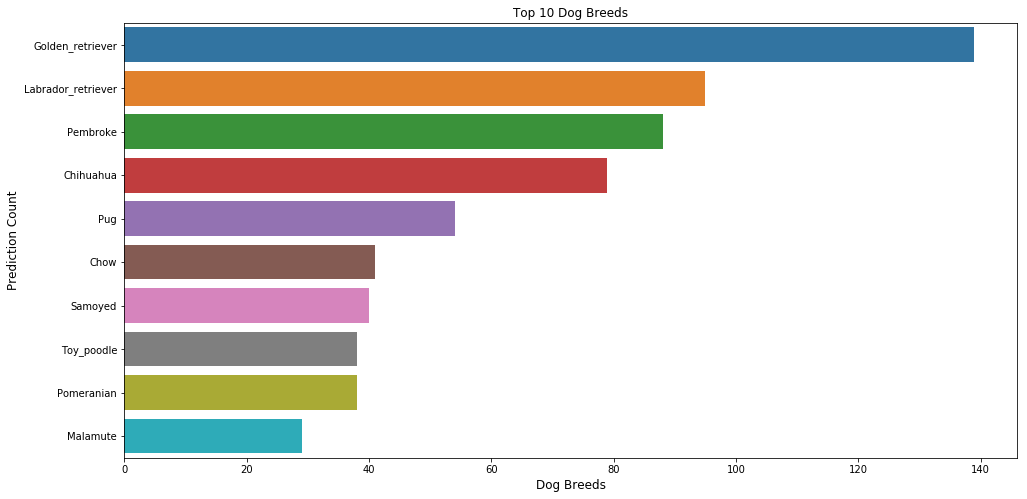

In [104]:
plt.figure(figsize=(16,8))

sns.barplot(x=prediction_value[1:11], y=prediction_index[1:11], data=df_vis);
plt.title('Top 10 Dog Breeds')
plt.xlabel("Dog Breeds",fontsize = 12);
plt.ylabel("Prediction Count",fontsize = 12);

#### Plotting the distribution of favorite from df_vis dataset.

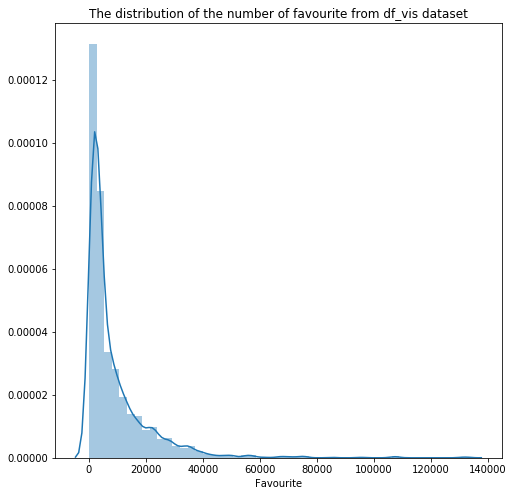

In [105]:
plt.figure(figsize=(8,8))
sns.distplot(df_vis['favorite_count']);
plt.xlabel("Favourite")
plt.title("The distribution of the number of favourite from df_vis dataset");

In [106]:
df_vis['favorite_count'].describe()

count    1995.000000  
mean     8891.310777  
std      12211.722542 
min      81.000000    
25%      1976.000000  
50%      4134.000000  
75%      11306.000000 
max      132810.000000
Name: favorite_count, dtype: float64

#### Plotting the distribution of favourite from Golden Retriever.

In [107]:
df_golden = df_vis.query('prediction == "Golden_retriever"')

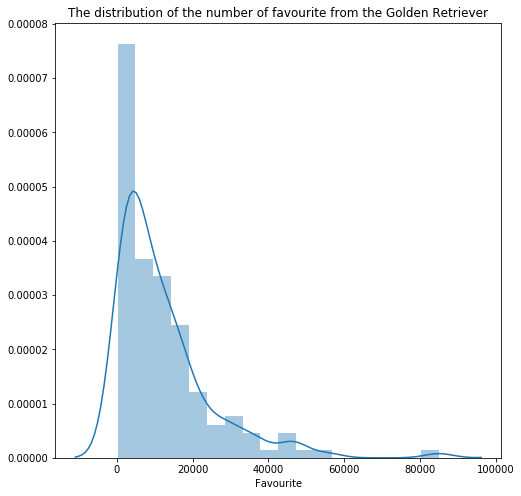

In [108]:
plt.figure(figsize=(8,8))
sns.distplot(df_golden['favorite_count']);
plt.xlabel("Favourite")
plt.title("The distribution of the number of favourite from the Golden Retriever");

In [109]:
df_golden['favorite_count'].describe()

count    139.000000  
mean     12205.949640
std      12986.086286
min      198.000000  
25%      3554.500000 
50%      8046.000000 
75%      16247.000000
max      85011.000000
Name: favorite_count, dtype: float64

#### Scatter polt between rating and retweet  to find the relationship.

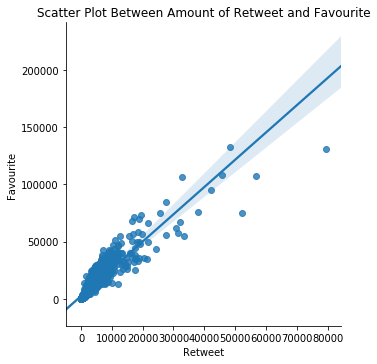

In [110]:
sns.lmplot(x='retweet_count', y='favorite_count', data=df_vis[['retweet_count', 'favorite_count']]);
plt.xlabel("Retweet")
plt.ylabel("Favourite")
plt.title("Scatter Plot Between Amount of Retweet and Favourite");

#### Plot correlation plot for Retweet Count, Favorite Count and Ratings to find the relationship

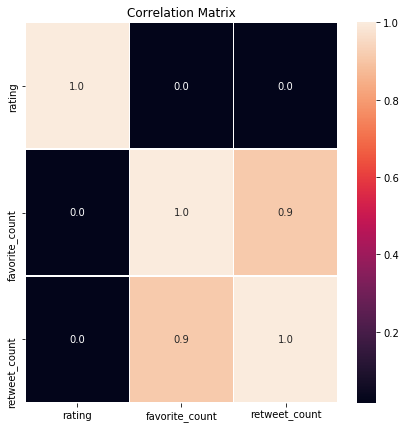

In [111]:
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(df_vis[['rating', 'favorite_count', 'retweet_count']].corr(), annot=True, linewidths=.5, fmt= '.1f')
plt.title('Correlation Matrix');

#### Plot a bar chart to visualize how many sources came from.

In [112]:
df_vis.source.value_counts().index

Index(['Twitter for iPhone', 'Twitter Web Client', 'TweetDeck'], dtype='object')

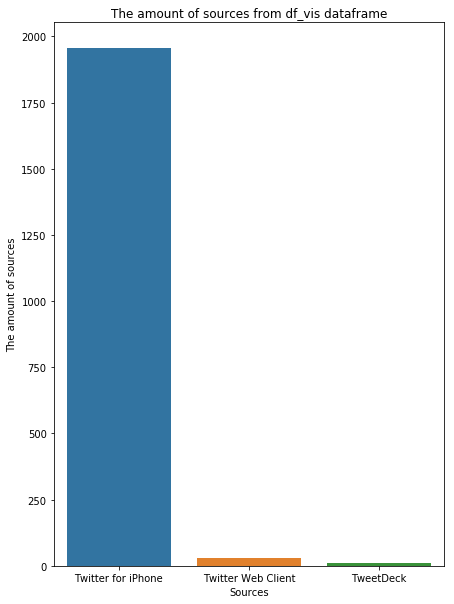

In [113]:
plt.figure(figsize=(7,10))
sns.countplot(x='source', data=df_vis);
plt.xlabel("Sources")
plt.ylabel("The amount of sources")
plt.title("The amount of sources from df_vis dataframe");

In [114]:
df_vis.source.value_counts()

Twitter for iPhone    1956
Twitter Web Client    28  
TweetDeck             11  
Name: source, dtype: int64